In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's read the dataset. You need to download the dataset (Scenario 10) from here https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/capture20110818.pcap.netflow.labeled and put it in the dataset folder. We rename the file to `capture-scenario10.pcap.netflow.labeled`

In [ ]:
dataset = pd.read_csv('dataset/capture-scenario10.pcap.netflow.labeled', delim_whitespace=True,skiprows=1,header=None)
dataset.columns = ["Date","Start","Duration","Protocol", "Source_IP","->","Destination_IP", "Flags","Tos","Packets"
                            ,"Bytes", "Flows","Label"]

In [19]:
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,321,1,Background
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,40095,1,Background
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,1909200,1,Background
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,66,1,Background
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,169,1,Background


First, let's remove all background flows

In [22]:
dataset = dataset.loc[dataset['Label'] != 'Background']
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13:80,->,147.32.85.88:56949,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110:48102,->,74.125.232.214:443,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88:56949,->,147.32.80.13:80,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59:2768,->,74.125.108.208:80,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59:56058,->,74.125.232.215:443,A_,0,1,60,1,LEGITIMATE


In [23]:
len(dataset)

645358

In [24]:
# remove port information
dataset['Source_IP'] = dataset['Source_IP'].apply(lambda x: x.split(":")[0])
dataset['Destination_IP'] = dataset['Destination_IP'].apply(lambda x: x.split(":")[0])
dataset.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [49]:
# convert to datetime
dataset['Start'] = dataset['Date'] + ' ' + dataset['Start']
dataset['Start'] = pd.to_datetime(dataset['Start'])
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [50]:
# infected host list from https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/
infected_hosts = ["147.32.84.165", "147.32.84.191", "147.32.84.192", "147.32.84.193", "147.32.84.204", "147.32.84.205", "147.32.84.206", "147.32.84.207", "147.32.84.208", "147.32.84.209"]

In [51]:
infected_flow_sample = dataset[(dataset['Source_IP'] == "147.32.84.165") | (dataset['Destination_IP'] == "147.32.84.165")]
normal_flow_sample = dataset[(dataset['Source_IP'] == "147.32.84.170") & (dataset['Label'] == 'LEGITIMATE')]

In [52]:
infected_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
299473,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,64,1,Botnet
299474,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.80.9,->,147.32.84.165,INT,0,1,139,1,Botnet
300156,2011-08-18,2011-08-18 10:38:00.695,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,87,1,Botnet
300158,2011-08-18,2011-08-18 10:38:00.705,0.000,UDP,147.32.80.9,->,147.32.84.165,INT,0,1,503,1,Botnet
300159,2011-08-18,2011-08-18 10:38:00.706,0.043,TCP,147.32.84.165,->,74.125.232.206,SRPA_,0,4,629,1,Botnet


In [60]:
infected_flow_sample['Packets'].describe()

count    29526.000000
mean        12.038034
std         84.293063
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1000.000000
Name: Packets, dtype: float64

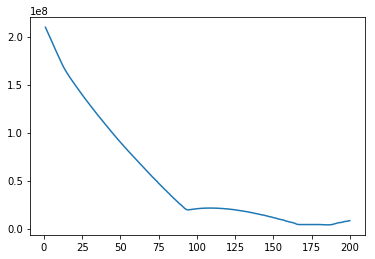

In [99]:
# ELBOW method 
max_k = 200
packets = infected_flow_sample['Packets'].sort_values()
sse_list = []
for k in range(1,max_k+1):
    sse = 0
    clusters = np.array_split(packets,k)
    for ii in range(k):
        # calculate mean of the cluster
        current_cluster = clusters[ii]
        cluster_mean = np.mean(current_cluster)
        # for each data point, calculate squared error
        for datapoint in current_cluster:
            sse = sse + pow(datapoint - cluster_mean,2)
    sse_list.append(sse)
plt.plot(range(1,max_k+1), sse_list)